In [1]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
from statsmodels.stats.multitest import multipletests

from collections import namedtuple
from scipy import special
import matplotlib
matplotlib.rcParams['figure.dpi'] = 500
def welch_anova_np(*args, var_equal=False):
    # https://svn.r-project.org/R/trunk/src/library/stats/R/oneway.test.R
    # translated from R Welch ANOVA (not assuming equal variance)

    F_onewayResult = namedtuple('F_onewayResult', ('statistic', 'pvalue'))

    args = [np.asarray(arg, dtype=float) for arg in args]
    k = len(args)
    ni =np.array([len(arg) for arg in args])
    mi =np.array([np.mean(arg) for arg in args])
    vi =np.array([np.var(arg,ddof=1) for arg in args])
    wi = ni/vi

    tmp =sum((1-wi/sum(wi))**2 / (ni-1))
    tmp /= (k**2 -1)

    dfbn = k - 1
    dfwn = 1 / (3 * tmp)

    m = sum(mi*wi) / sum(wi)
    f = sum(wi * (mi - m)**2) /((dfbn) * (1 + 2 * (dfbn - 1) * tmp))
    prob = special.fdtrc(dfbn, dfwn, f)   # equivalent to stats.f.sf
    return F_onewayResult(f, prob)

In [2]:
peak_area_filename = "../data/09_25_20_hamster_samples_pHILIC_peak_areas.csv"
experiment_parameters = "../data/experiment_parameters_hamster_pHILIC.csv"

In [3]:
data = pd.read_csv(peak_area_filename)
data

,Compound Name,Compound Group,Formula,Mass,RT,CAS ID,blank-1_6540,blank-2_6540,blank-3_6540,L1 H-472_1M_6540,...,L40 H-497_16F_6540,L5 H-475_5M_6540,L6 H-490_6M_6540,L7 H-501_7M_6540,L8 H-489_8M_6540,L9 H-494_1C_6540,QC-L pool-1_6540,QC-L pool-2_6540,QC-L pool-3_6540,QC-L pool-4_6540
0,1_(Z)-3-Hydroxyoctadec-7-enoic acid,covid_id_updated,C18H34O3,298.250795,0.82,NaN,5227,17457,23242,317098,...,1055357,740901,481722,599330,375391,369224,22513,346783,1859915,279961
1,2_1 5 Anhydro D glucitol,covid_id_updated,C6H12O5,164.068474,4.58,NaN,2434,1891,2030,116453,...,230675,154528,102997,160660,157916,193781,3376,198836,134435,156936
2,5_14 Z Eicosenoic acid,covid_id_updated,C20H38O2,310.287181,0.79,NaN,2745,3279,3708,35079,...,108761,159274,78629,61336,41296,61920,4165,55025,142362,37137
3,6_16 Hydroxyhexadecanoic acid,covid_id_updated,C16H32O3,272.235145,0.82,NaN,15266,4962,20167,511888,...,752288,987782,570002,600980,555821,616374,23378,442778,746658,362152
4,8_2 Aminoadipic acid,covid_id_updated,C6H11NO4,161.068808,6.85,NaN,724,1097,825,25691,...,21427,23944,32006,19071,25478,25776,1690,23728,18538,23928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,238_Skatole,iHILICpos,C9H9N,131.073499,4.69,NaN,3087,2944,2880,75462,...,54280,56226,75439,56172,48928,34792,76374,66966,55314,66326
194,239_Taurine,iHILICpos,C2H7NO3S,125.014664,6.17,NaN,1664,1578,1445,23157976,...,23667788,30220338,27826872,20023724,16817188,18464744,24548088,24728708,22337752,21356994
195,242_trans 3 Indoleacrylic acid,iHILICpos,C11H9NO2,187.063329,4.67,NaN,2933,3748,3766,3403534,...,3289655,3350703,3848672,2647375,1624559,1936637,3567970,3030038,3405147,3446572
196,N-methyl nicotinamide,NMN,C7H8N2O,136.063663,10.43,NaN,9014,4386,4856,445489,...,349377,569316,596777,340987,260056,269516,352473,404755,374971,361361


In [4]:
sample_info = pd.read_csv(experiment_parameters,index_col=1)
sample_info

,#,Grouping,Sample Information,Group,Day post infection,Group-day
Sample name,,,,,,
L1 H-472_1M_6540,1,Lung,Mock (Day 4),Mock,4,Mock_d4
L2 H-507_2M_6540,2,Lung,Mock (Day 4),Mock,4,Mock_d4
L3 H-464_3M_6540,3,Lung,Mock (Day 4),Mock,4,Mock_d4
L4 H-482_4M_6540,4,Lung,Mock (Day 4),Mock,4,Mock_d4
L5 H-475_5M_6540,7,Lung,Mock (Day 14),Mock,14,Mock_d14
L6 H-490_6M_6540,8,Lung,Mock (Day 14),Mock,14,Mock_d14
L7 H-501_7M_6540,9,Lung,Mock (Day 14),Mock,14,Mock_d14
L8 H-489_8M_6540,10,Lung,Mock (Day 14),Mock,14,Mock_d14
L10 H-513_2C_6540,13,Lung,SARS-CoV-2 Day 2 post-infection,SARS-CoV-2,2,SARS-CoV-2_d2


In [5]:
mol_names = data["Compound Name"].values
samples = sample_info.index.values
area_cols = [x for x in data.columns.values if x in samples]
print(len(area_cols),len(samples))
data_matrix = np.log2(data[area_cols].transpose())
data_matrix.columns = np.array(mol_names)

samplesOfInterest = [x for x in data_matrix.index.values if sample_info.at[x,"Group"] in ["SARS-CoV-2","Influenza","Mock"] and sample_info.at[x,"Day post infection"] in [2,4,6,14]]
print(len(samplesOfInterest))
data_matrix = data_matrix.loc[samplesOfInterest,:]

def marker(ty):
    if ty == "Influenza":
        return 1
    elif ty == "SARS-CoV-2":
        return 2
    else:
        return 0
sample_kind_mapping = [(marker(sample_info.at[x,"Group"]),sample_info.at[x,"Day post infection"]) for x in data_matrix.index.values]

unique_groups = set(sample_kind_mapping)
comparision_groups = list(unique_groups)

alpha = 0.05
pvals = []
for x in range(len(mol_names)):
    sub = data_matrix[mol_names[x]]
    stat,pval = welch_anova_np(*[[sub[i] for i in range(len(sample_kind_mapping)) if sample_kind_mapping[i] == p] for p in comparision_groups])
    pvals.append(pval)
    
sig_mets = []
reject,pvals_corr,_,_ = multipletests(pvals,alpha,method="fdr_bh")
for name,p in zip(range(len(mol_names)),pvals_corr):
    if p < alpha:
        sig_mets.append(name)

print(len(sig_mets))

order = list(range(len(data_matrix)))
order.sort(key=lambda x: sample_kind_mapping[x])
data_matrix_sorted = data_matrix.iloc[order,sig_mets]

40 40
40
12


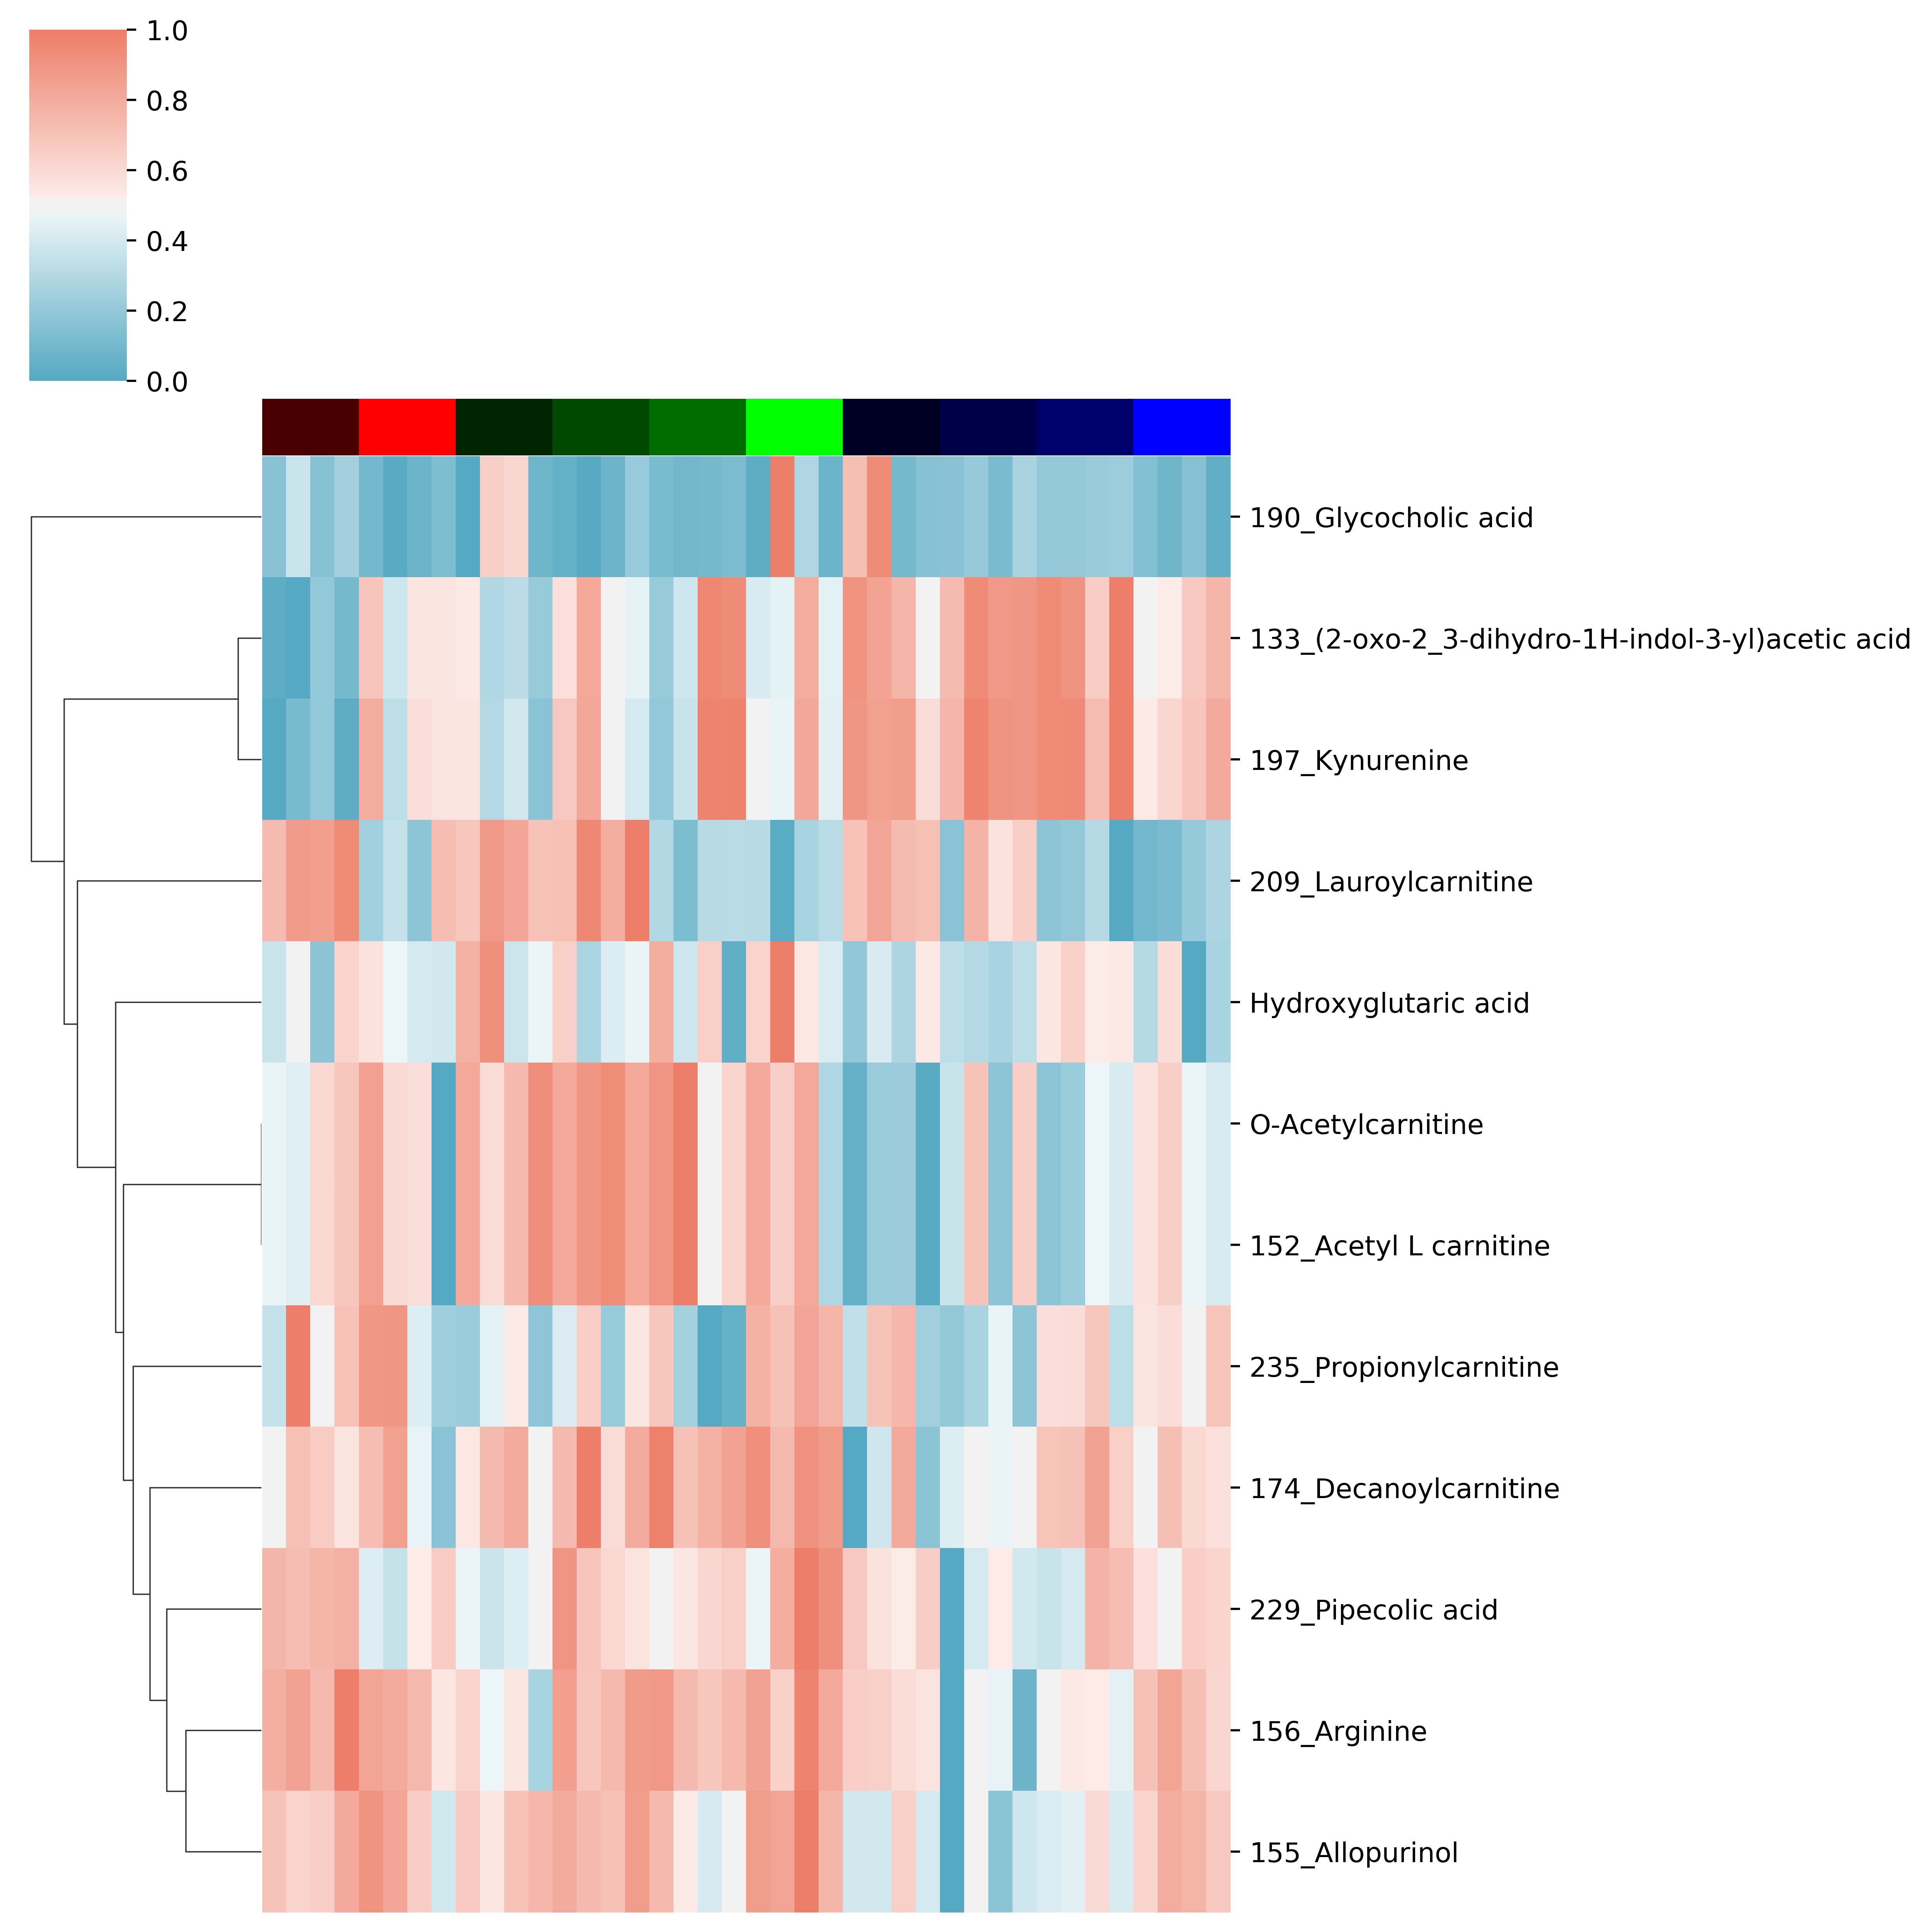

In [6]:
colors = [(1,0,0),(0,1,0),(0,0,1)]
sb.clustermap(data_matrix_sorted.transpose(),col_cluster=False,col_colors=[np.array(colors[sample_kind_mapping[x][0]]) * sample_kind_mapping[x][1]/14 for x in order],standard_scale=0,xticklabels=False,yticklabels=True,cmap=sb.diverging_palette(220, 20, l=65, center="light", as_cmap=True))

In [7]:
mol_names = data["Compound Name"].values
catagories = data["Compound Group"].values
samples = sample_info.index.values
area_cols = [x for x in data.columns.values if x in samples]
print(len(area_cols),len(samples))
data_matrix = np.log2(data[area_cols].transpose())
data_matrix.columns = np.array(mol_names)

samplesOfInterest = [x for x in data_matrix.index.values if sample_info.at[x,"Group"] in ["SARS-CoV-2","Mock"] and sample_info.at[x,"Day post infection"] in [2,4,6,14]]
print(len(samplesOfInterest))
data_matrix = data_matrix.loc[samplesOfInterest,:]

def marker(ty):
    if ty == "Influenza":
        return 1
    elif ty == "SARS-CoV-2":
        return 2
    else:
        return 0
sample_kind_mapping = [(marker(sample_info.at[x,"Group"]),sample_info.at[x,"Day post infection"]) for x in data_matrix.index.values]

unique_groups = set(sample_kind_mapping)
comparision_groups = list(unique_groups)

alpha = 0.05
pvals = []
for x in range(len(mol_names)):
    sub = data_matrix[mol_names[x]]
    stat,pval = welch_anova_np(*[[sub[i] for i in range(len(sample_kind_mapping)) if sample_kind_mapping[i] == p] for p in comparision_groups])
    pvals.append(pval)
    
sig_mets = []
reject,pvals_corr,_,_ = multipletests(pvals,alpha,method="fdr_bh")
for name,p,g in zip(range(len(mol_names)),pvals_corr,catagories):
    if g == "TCA":
        print(mol_names[name],p)
        sig_mets.append(name)


print(len(sig_mets))

newMat = np.zeros((len(set(sample_kind_mapping)),len(sig_mets)))
sampleOrder = list(set(sample_kind_mapping))
sampleOrder.sort()
sampleCounts = [len([z for z in sample_kind_mapping if z == x]) for x in sampleOrder]
for x in range(len(data_matrix)):
    ind = sampleOrder.index(sample_kind_mapping[x])
    newMat[ind,:] += data_matrix.iloc[x,sig_mets].values / sampleCounts[ind]
    
data_matrix_sorted = newMat

40 40
24
alpha-Ketoglutaric Acid 0.6404699283039883
cis-Aconitic acid 0.8626275650497258
Citric Acid 0.863828220428483
Fumaric Acid 0.9195810286475897
Hydroxyglutaric acid 0.1161095554745846
Malic acid 0.909100083568384
Pyruvate 0.9736612698507165
Succinic acid 0.863828220428483
8


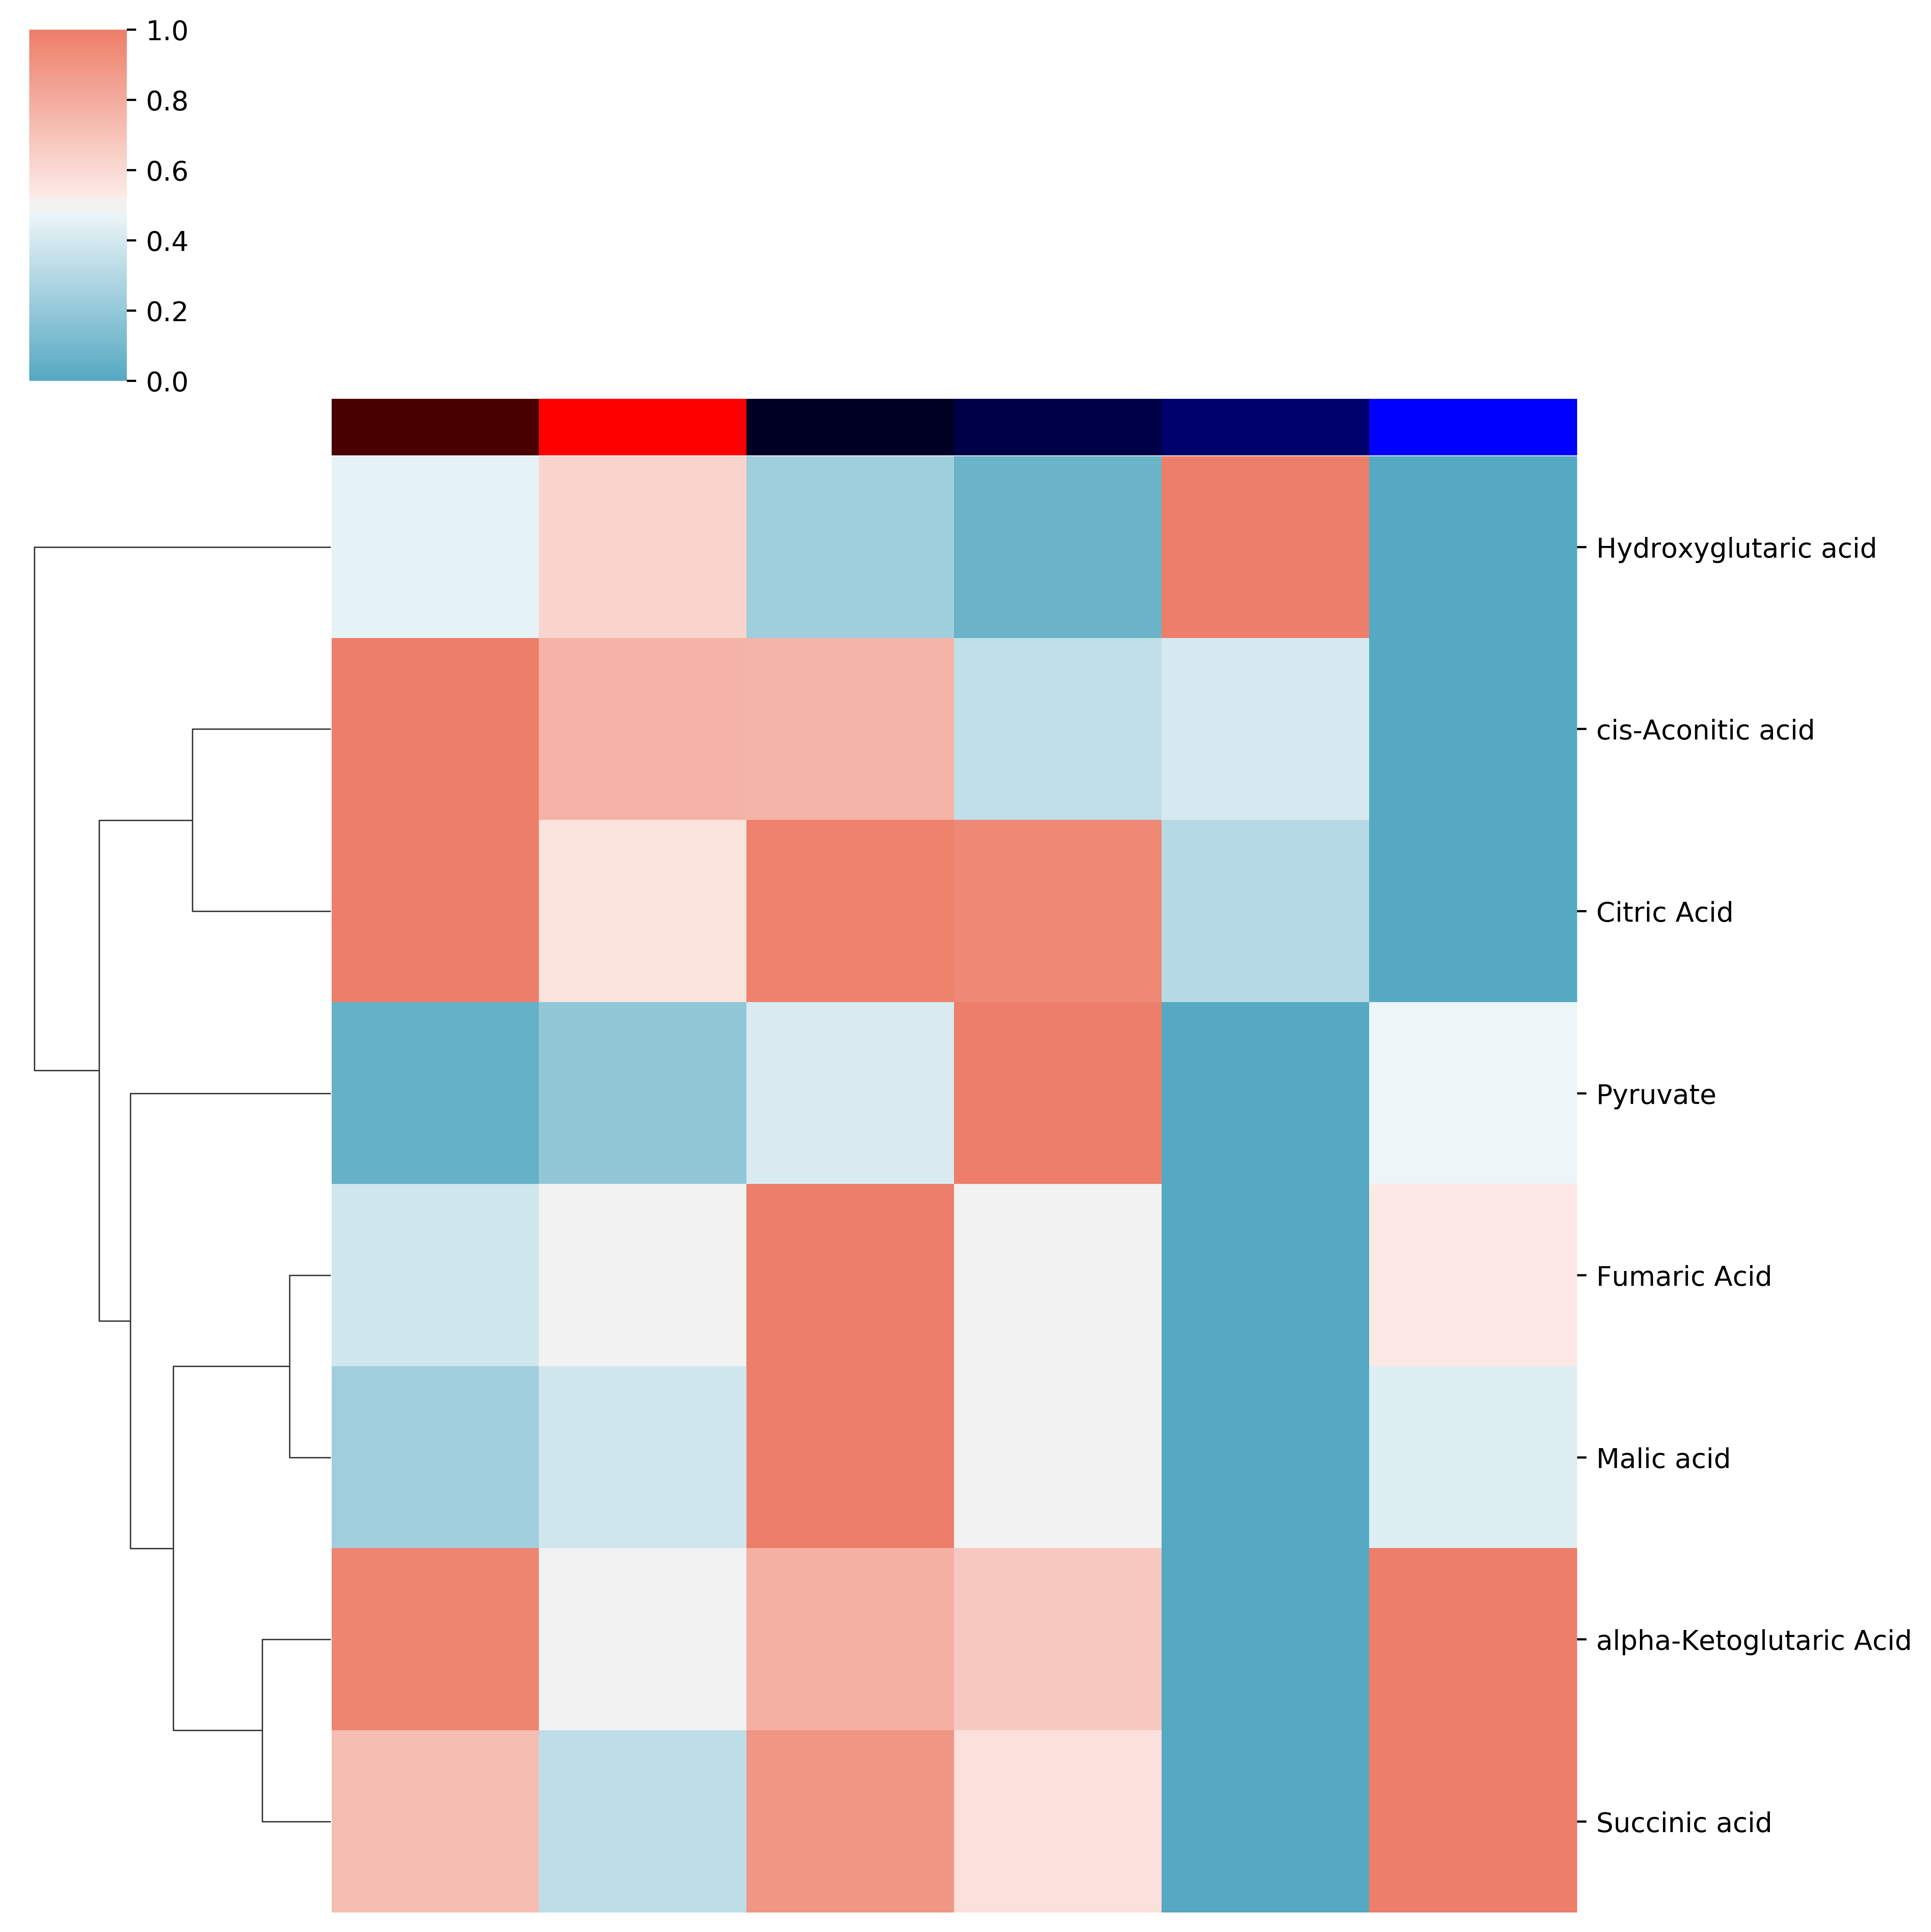

In [8]:
colors = [(1,0,0),(0,1,0),(0,0,1)]
sb.clustermap(data_matrix_sorted.transpose(),col_cluster=False,col_colors=[np.array(colors[sampleOrder[x][0]]) * sampleOrder[x][1]/14 for x in range(len(sampleOrder))],standard_scale=0,xticklabels=False,yticklabels=mol_names[sig_mets],cmap=sb.diverging_palette(220, 20, l=65, center="light", as_cmap=True))

In [9]:
print(data_matrix)

                       1_(Z)-3-Hydroxyoctadec-7-enoic acid  \
L1 H-472_1M_6540                                 18.274569   
L10 H-513_2C_6540                                19.614909   
L11 H-469 -1_3C_6540                             20.091802   
L12 H-516_4C_6540                                19.137049   
L13 H-487_5C_6540                                19.445203   
L14 H-514_6C_6540                                18.094305   
L15 H-469 -2 _7C_6540                            18.551581   
L16 H-488_8C_6540                                18.294042   
L17 H-463_9C_6540                                19.154853   
L18 H-509_10C_6540                               20.726269   
L19 H-504_11C_6540                               18.639743   
L2 H-507_2M_6540                                 18.658762   
L20 H-468_12C_6540                               17.835372   
L21 H-485_13C_6540                               19.283208   
L22 H-484_14C_6540                               18.725762   
L23 H-47

40 40
12
{'Influenza', 'Mock', 'SARS-CoV-2'}
alpha-Ketoglutaric Acid 0.8055406588404096
cis-Aconitic acid 0.8956437672123634
Citric Acid 0.7590233529762689
Fumaric Acid 0.9820067487137941
Hydroxyglutaric acid 0.7326455420620305
Malic acid 0.9847585470223728
Pyruvate 0.7896159932588525
Succinic acid 0.9735979100996661


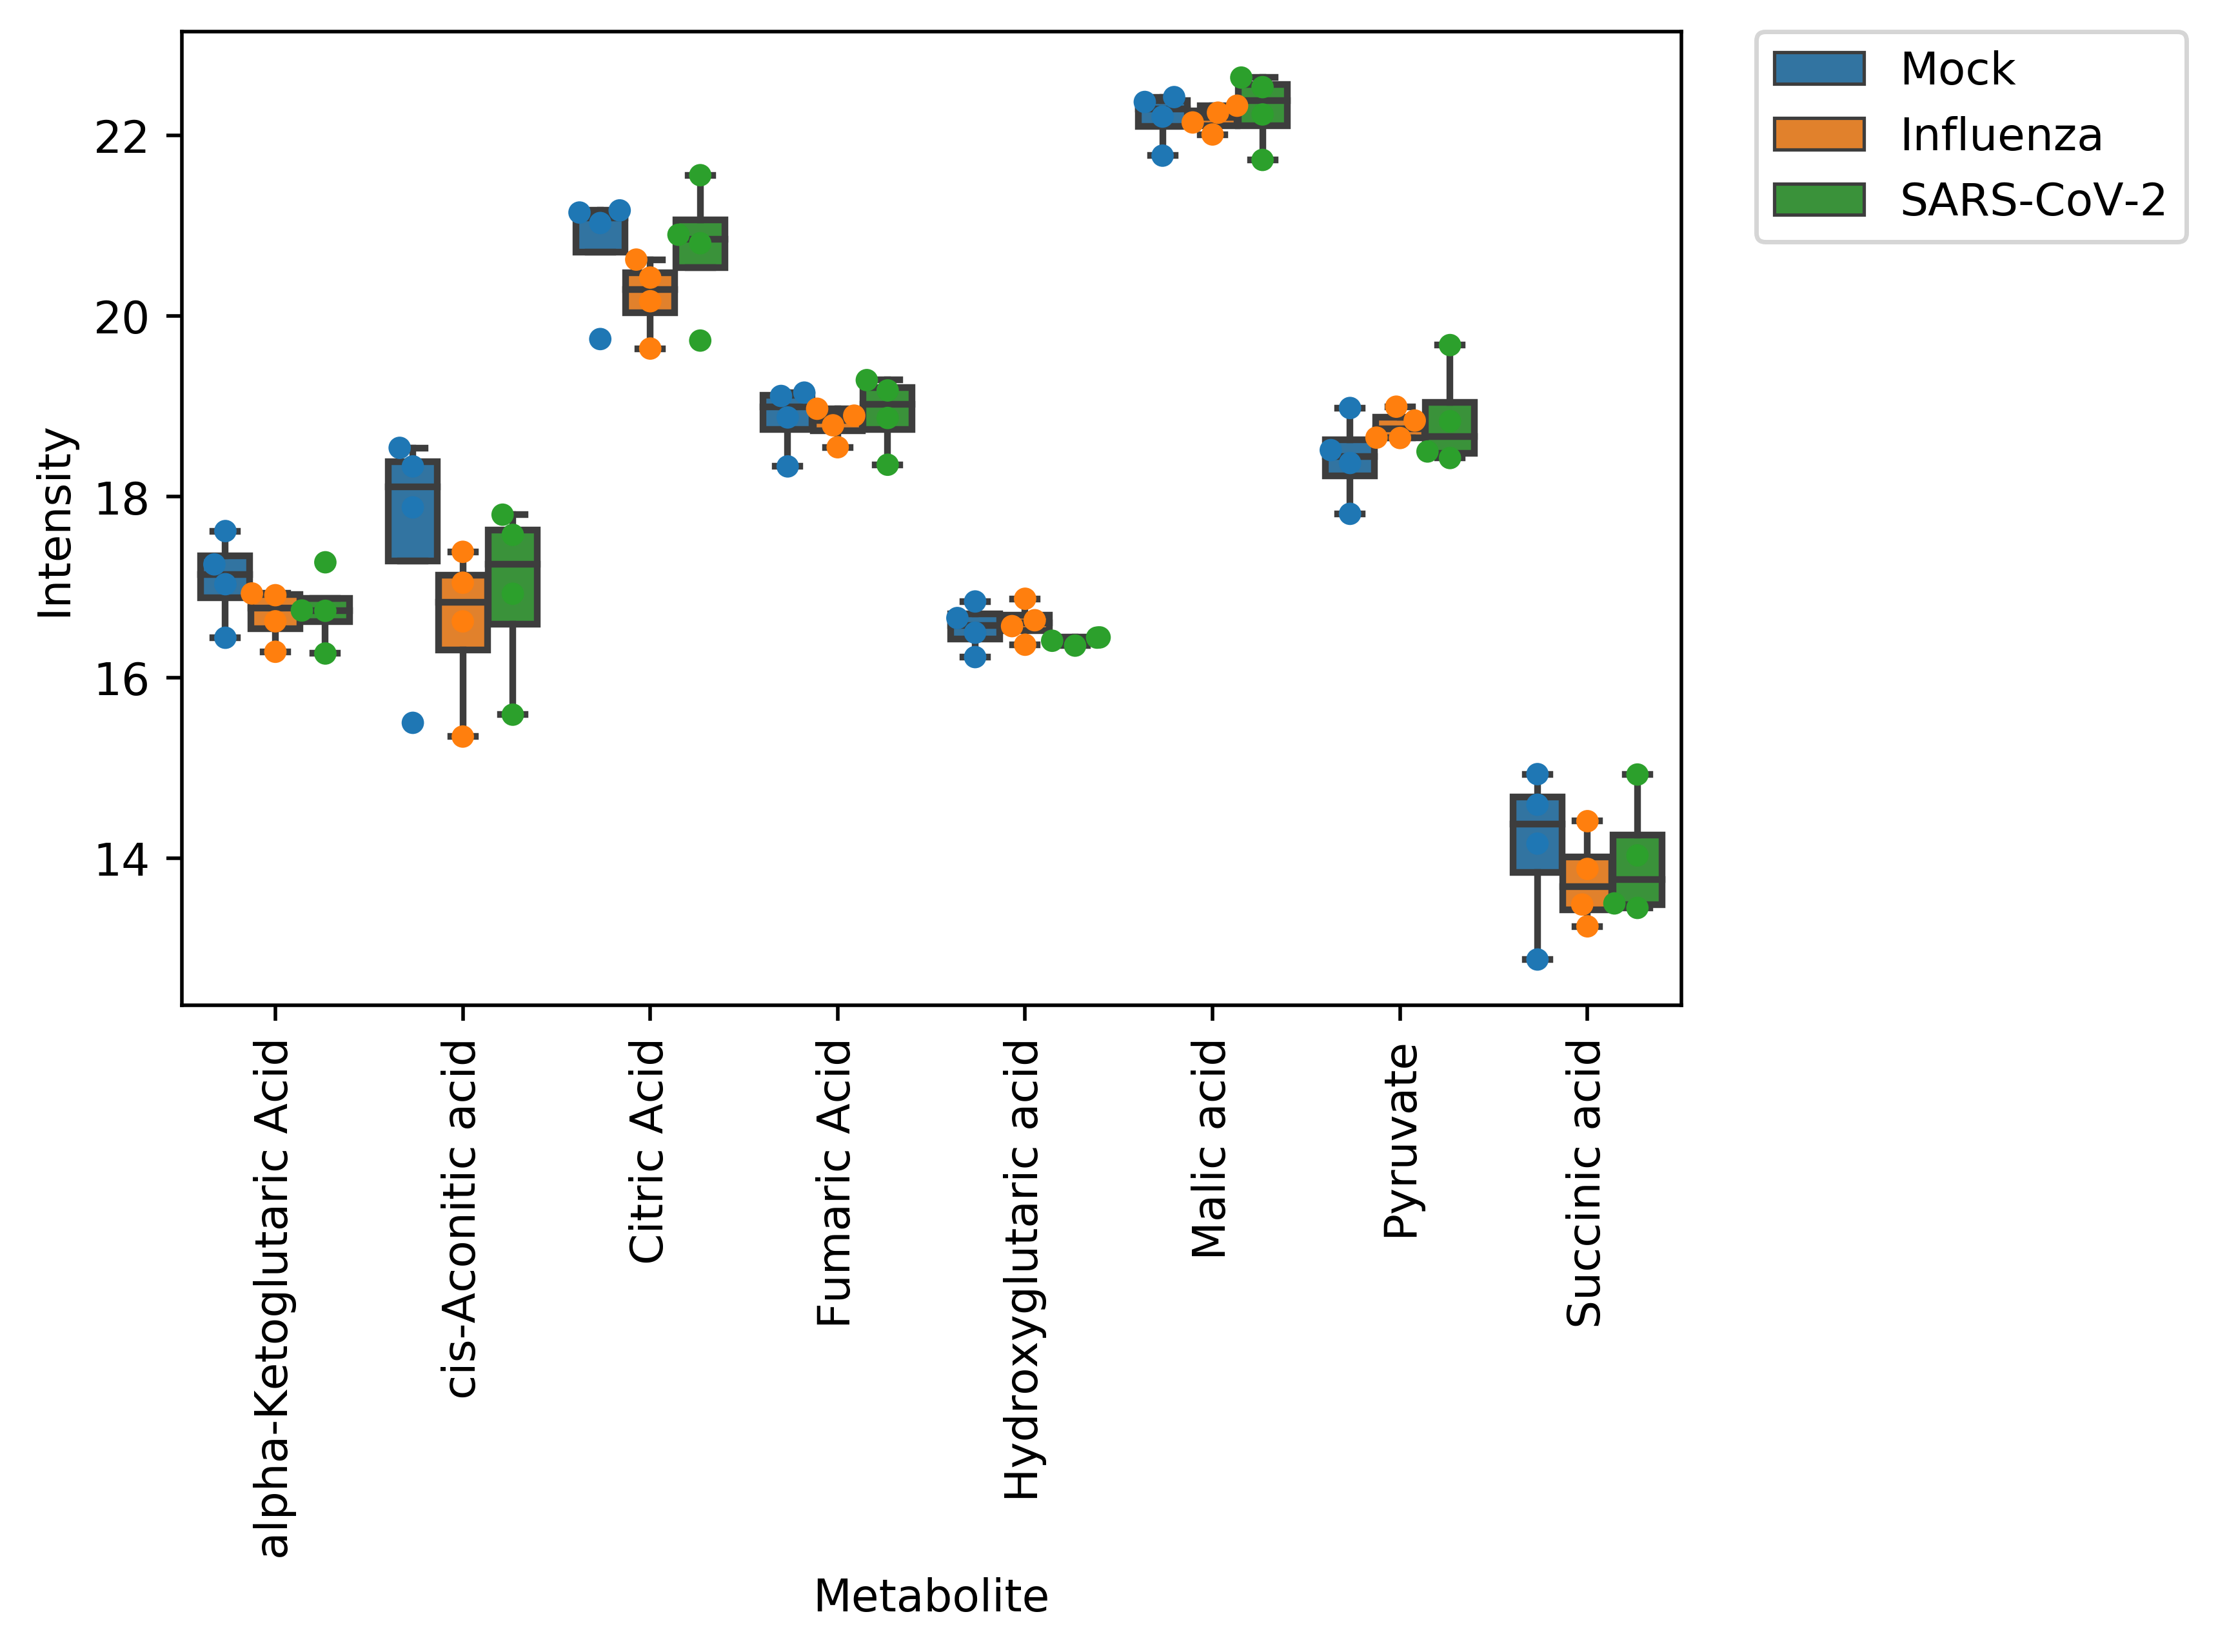

In [10]:
mol_names = data["Compound Name"].values
catagories = data["Compound Group"].values
samples = sample_info.index.values
area_cols = [x for x in data.columns.values if x in samples]
print(len(area_cols),len(samples))
data_matrix = np.log2(data[area_cols].transpose())
data_matrix.columns = np.array(mol_names)

samplesOfInterest = [x for x in data_matrix.index.values if (sample_info.at[x,"Group"] in ["SARS-CoV-2","Influenza"] and sample_info.at[x,"Day post infection"] in [4]) or (sample_info.at[x,"Group"] in ["Mock"] and sample_info.at[x,"Day post infection"] in [4])]
print(len(samplesOfInterest))
data_matrix = data_matrix.loc[samplesOfInterest,:]

def marker(ty):
    if ty == "Influenza":
        return 1
    elif ty == "SARS-CoV-2":
        return 2
    else:
        return 0
sample_kind_mapping = [sample_info.at[x,"Group"] for x in data_matrix.index.values]

unique_groups = set(sample_kind_mapping)
comparision_groups = list(unique_groups)
print(unique_groups)

alpha = 0.05
pvals = []
for x in range(len(mol_names)):
    sub = data_matrix[mol_names[x]]
    stat,pval = welch_anova_np(*[[sub[i] for i in range(len(sample_kind_mapping)) if sample_kind_mapping[i] == p] for p in comparision_groups])
    pvals.append(pval)
    
sig_mets = []
reject,pvals_corr,_,_ = multipletests(pvals,alpha,method="fdr_bh")
for name,p,g in zip(range(len(mol_names)),pvals_corr,catagories):
    if "TCA" in g:
        print(mol_names[name],p)
        sig_mets.append(name)
        
plot_dict = {}
ind = 0
for x in range(len(data_matrix)):
    for met in sig_mets:
        plot_dict[ind] = {"Group":sample_kind_mapping[x],"Metabolite":mol_names[met],"Intensity":data_matrix.iloc[x,met]}
        ind += 1
        
plt.figure()
ax = sb.boxplot(data=pd.DataFrame.from_dict(plot_dict,orient="index"),x="Metabolite",y="Intensity",hue="Group",fliersize=0,hue_order=["Mock","Influenza","SARS-CoV-2"])
sb.swarmplot(data=pd.DataFrame.from_dict(plot_dict,orient="index"),x="Metabolite",y="Intensity",hue="Group",dodge=True,hue_order=["Mock","Influenza","SARS-CoV-2"])
plt.xticks(rotation=90)
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[:3], labels[:3], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


40 40
16
alpha-Ketoglutaric Acid 0.7014839729116075
cis-Aconitic acid 0.7788266391772566
Citric Acid 0.7783972279868632
Fumaric Acid 0.7934747962513533
Hydroxyglutaric acid 0.22526739932894865
Malic acid 0.7963485485993558
Pyruvate 0.9359006769063215
Succinic acid 0.7783972279868632
8


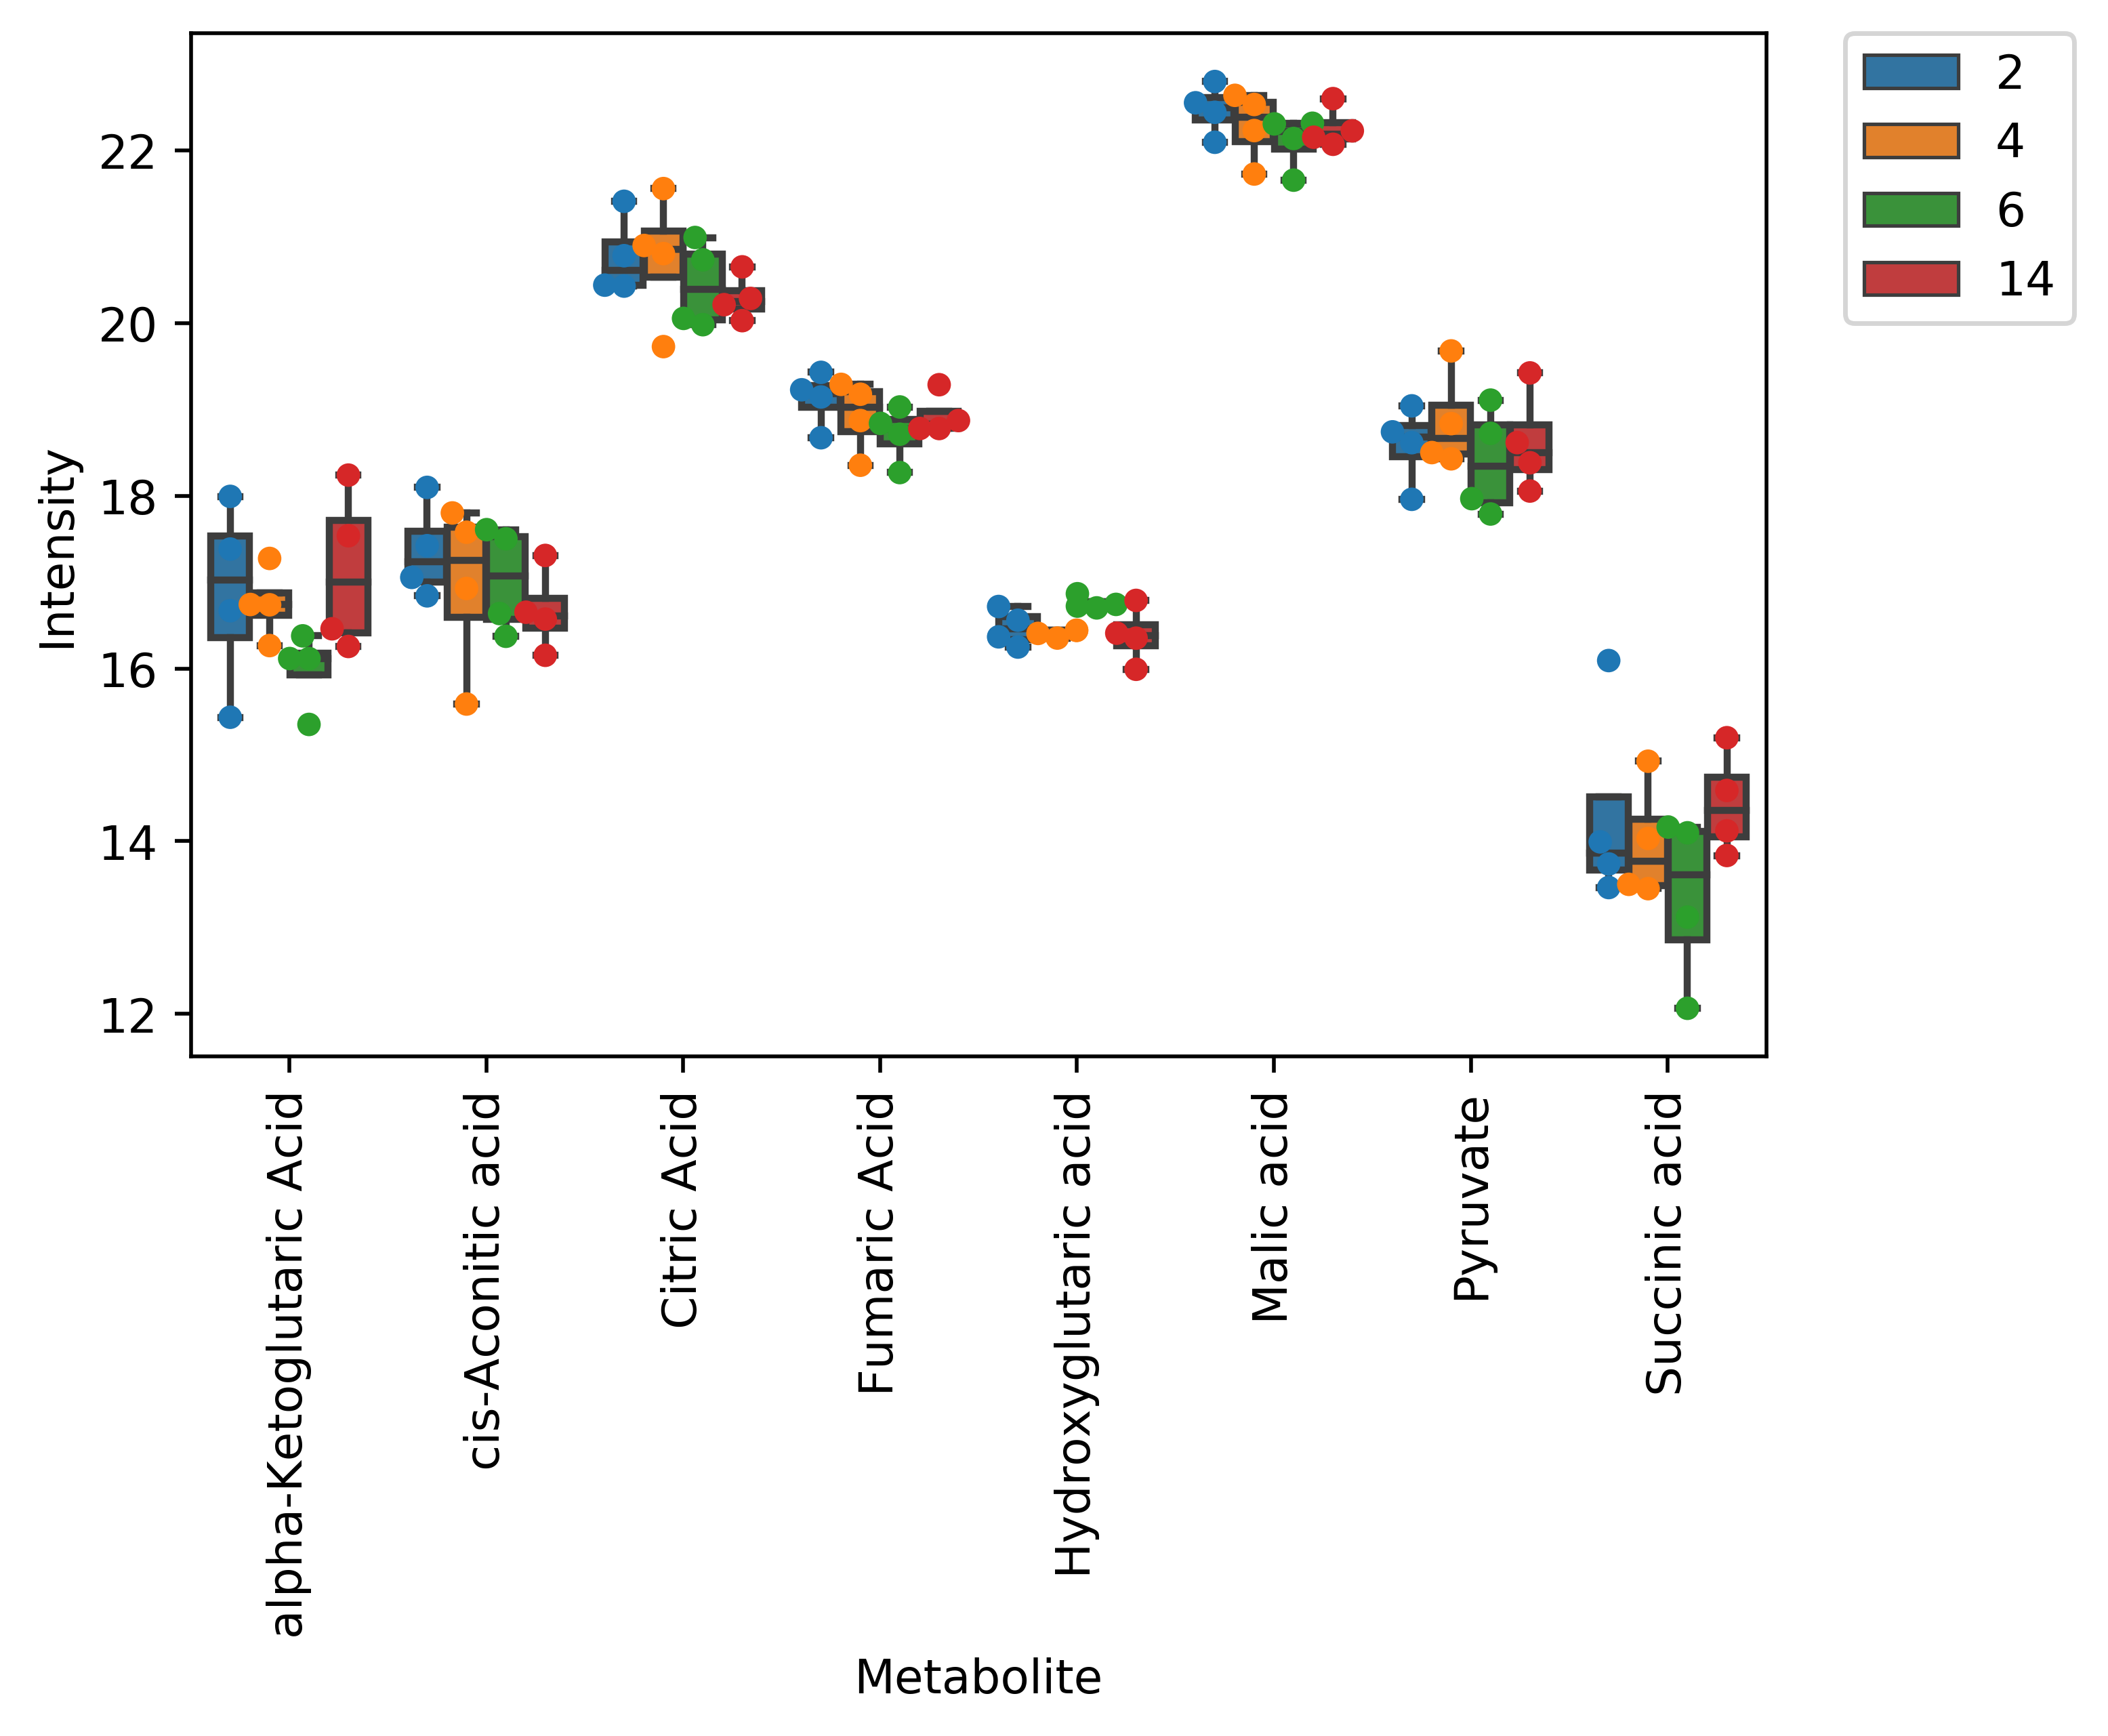

In [62]:
mol_names = data["Compound Name"].values
catagories = data["Compound Group"].values
samples = sample_info.index.values
area_cols = [x for x in data.columns.values if x in samples]
print(len(area_cols),len(samples))
data_matrix = np.log2(data[area_cols].transpose())
data_matrix.columns = np.array(mol_names)

samplesOfInterest = [x for x in data_matrix.index.values if (sample_info.at[x,"Group"] in ["SARS-CoV-2"] and sample_info.at[x,"Day post infection"] in [2,4,6,14])]
print(len(samplesOfInterest))
data_matrix = data_matrix.loc[samplesOfInterest,:]

def marker(ty):
    if ty == "Influenza":
        return 1
    elif ty == "SARS-CoV-2":
        return 2
    else:
        return 0
sample_kind_mapping = [sample_info.at[x,"Day post infection"] for x in data_matrix.index.values]

unique_groups = set(sample_kind_mapping)
comparision_groups = list(unique_groups)

alpha = 0.05
pvals = []
for x in range(len(mol_names)):
    sub = data_matrix[mol_names[x]]
    stat,pval = welch_anova_np(*[[sub[i] for i in range(len(sample_kind_mapping)) if sample_kind_mapping[i] == p] for p in comparision_groups])
    pvals.append(pval)
    
sig_mets = []
reject,pvals_corr,_,_ = multipletests(pvals,alpha,method="fdr_bh")
for name,p,g in zip(range(len(mol_names)),pvals_corr,catagories):
    if "TCA" in g:
        print(mol_names[name],p)
        sig_mets.append(name)
        
plot_dict = {}
ind = 0
for x in range(len(data_matrix)):
    for met in sig_mets:
        plot_dict[ind] = {"Day":sample_kind_mapping[x],"Metabolite":mol_names[met],"Intensity":data_matrix.iloc[x,met]}
        ind += 1
        
plt.figure()
ax = sb.boxplot(data=pd.DataFrame.from_dict(plot_dict,orient="index"),x="Metabolite",y="Intensity",hue="Day",fliersize=0)
sb.swarmplot(data=pd.DataFrame.from_dict(plot_dict,orient="index"),x="Metabolite",y="Intensity",hue="Day",dodge=True)
plt.xticks(rotation=90)
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[:4], labels[:4], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


print(len(sig_mets))



40 40
12
{'Influenza', 'Mock', 'SARS-CoV-2'}
188_Glutarylcarnitine 0.7300186907194598
192_Hexanoylcarnitine 0.8964294969669477
209_Lauroylcarnitine 0.7672223216063518
226_Octanoylcarnitine 0.9519093037095102
235_Propionylcarnitine 0.6880196309344385
O-Acetylcarnitine 0.3197062460359037
152_Acetyl L carnitine 0.3197062460359037
174_Decanoylcarnitine 0.6880196309344385


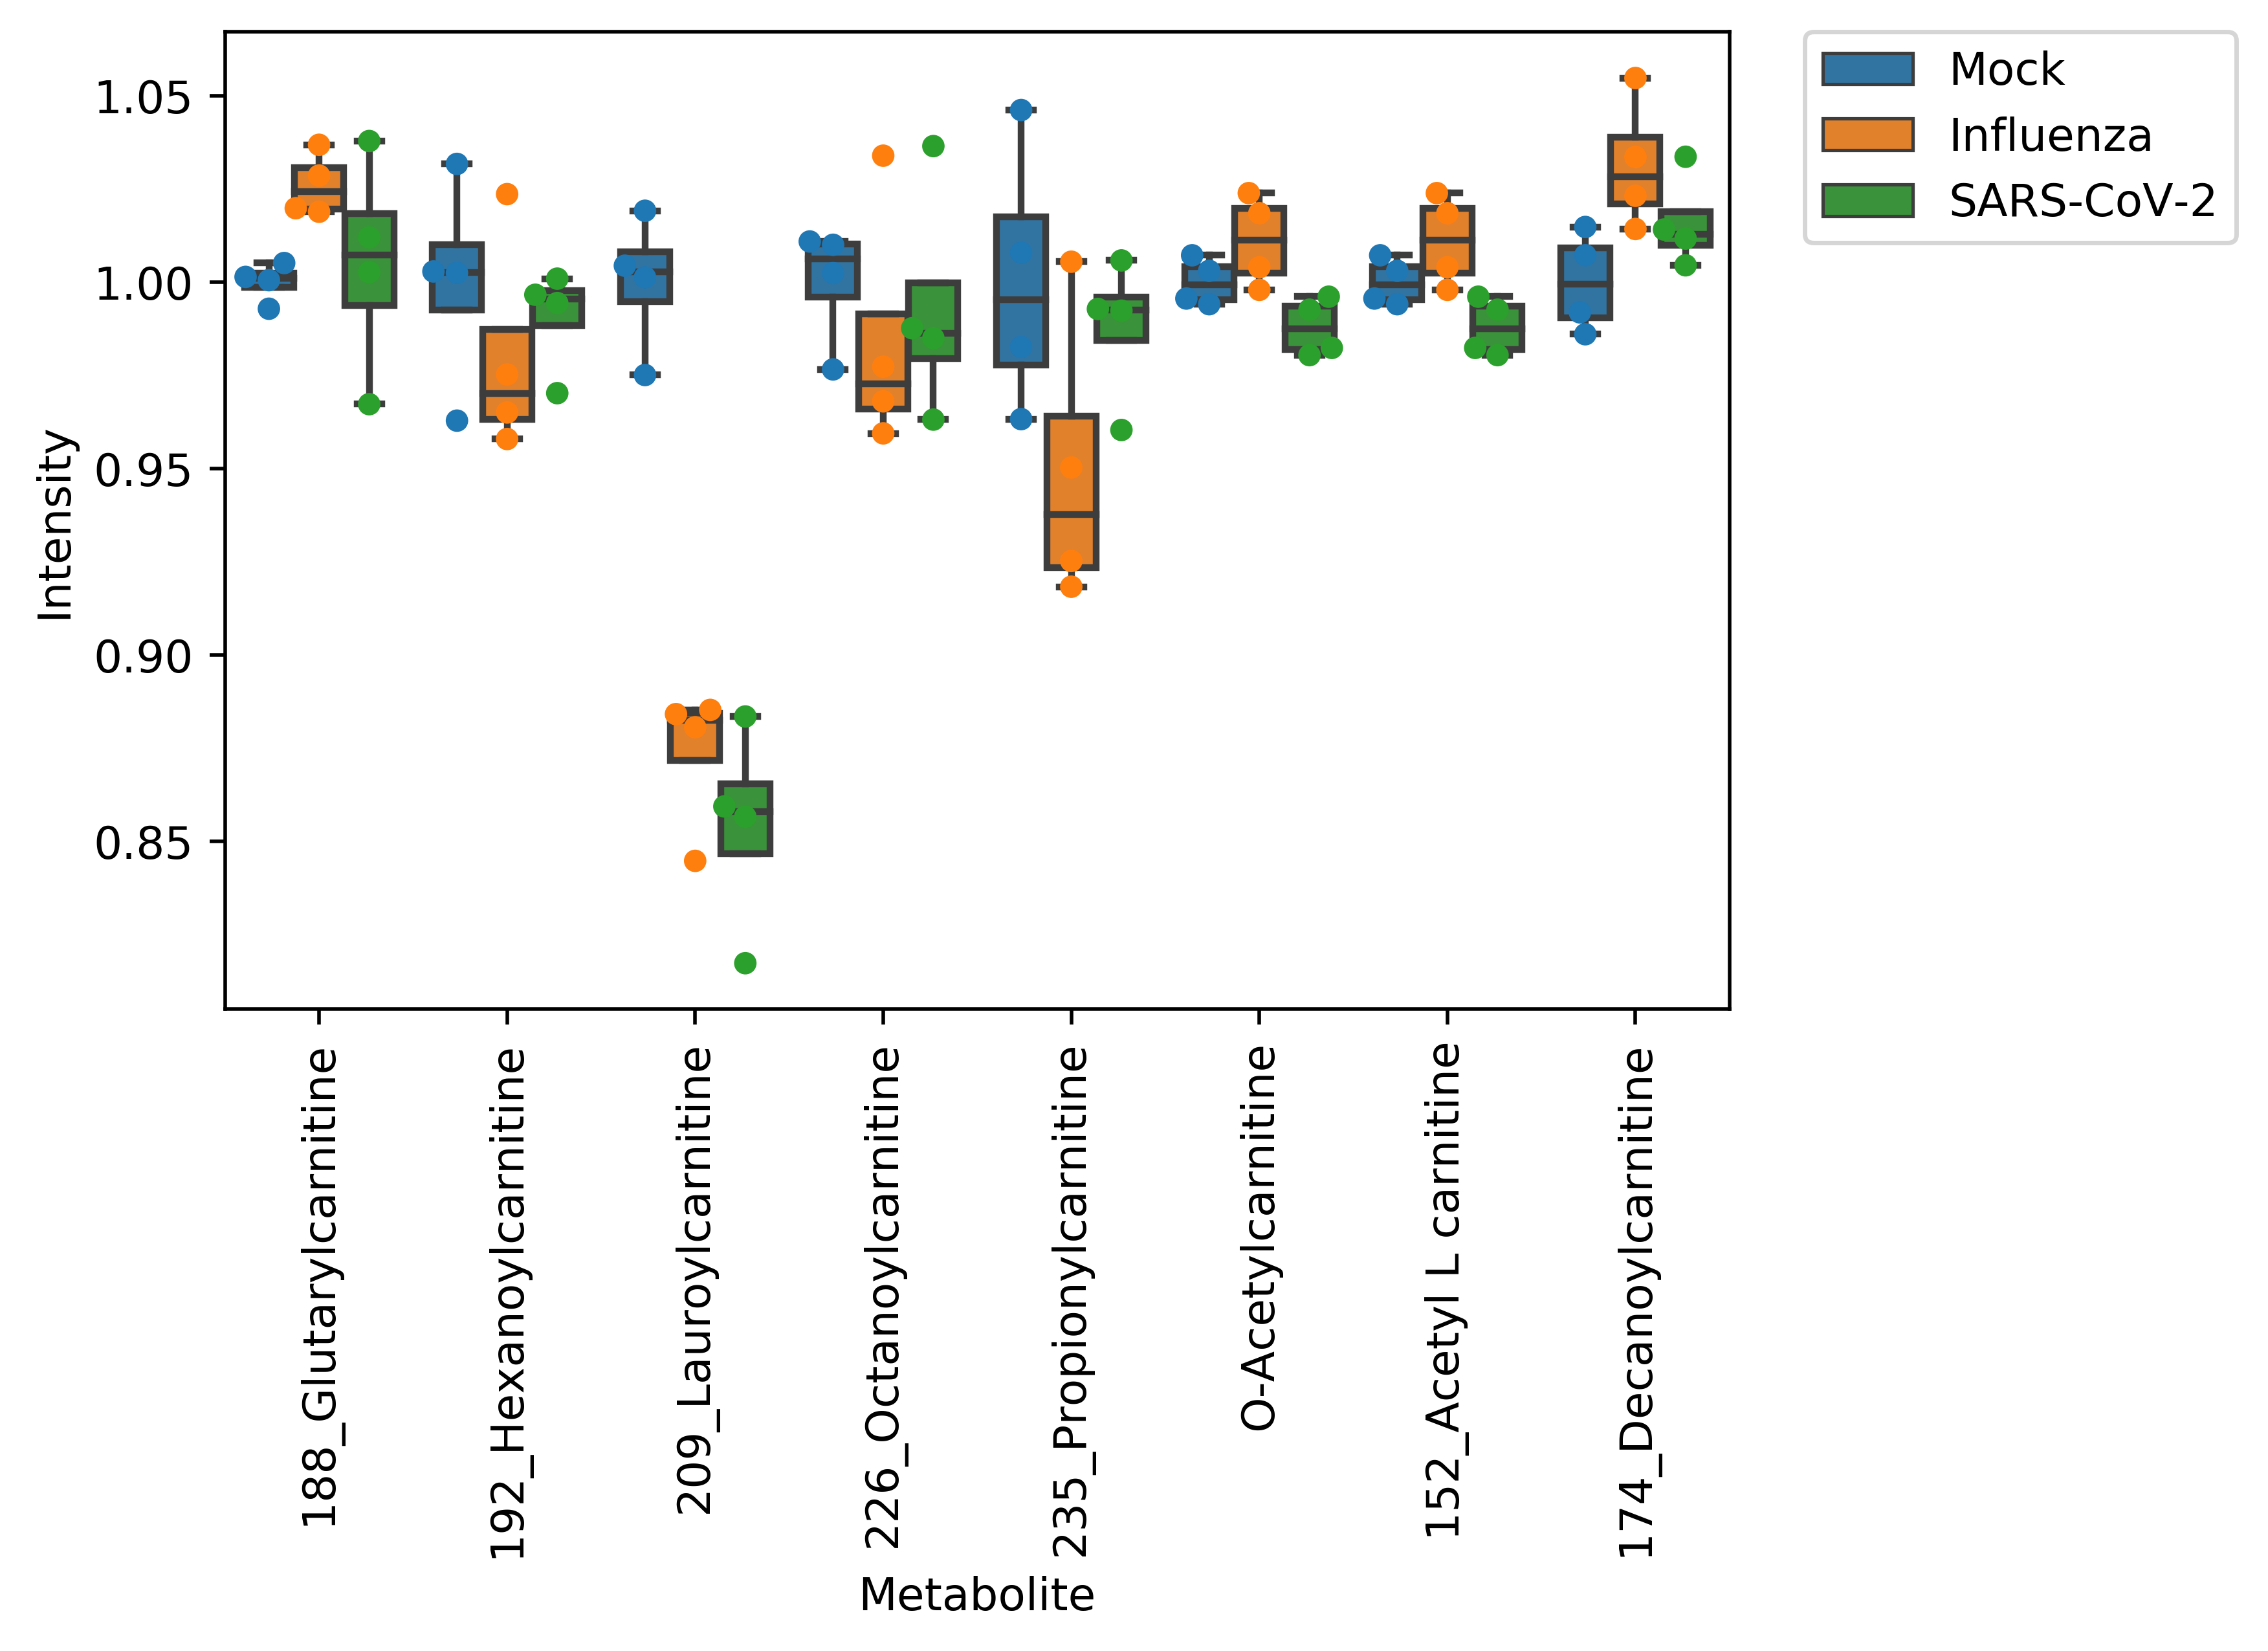

In [21]:
mol_names = data["Compound Name"].values
catagories = data["Compound Group"].values
samples = sample_info.index.values
area_cols = [x for x in data.columns.values if x in samples]
print(len(area_cols),len(samples))
data_matrix = np.log2(data[area_cols].transpose())
data_matrix.columns = np.array(mol_names)

samplesOfInterest = [x for x in data_matrix.index.values if (sample_info.at[x,"Group"] in ["SARS-CoV-2","Influenza"] and sample_info.at[x,"Day post infection"] in [6]) or (sample_info.at[x,"Group"] in ["Mock"] and sample_info.at[x,"Day post infection"] in [4])]
print(len(samplesOfInterest))
data_matrix = data_matrix.loc[samplesOfInterest,:]

def marker(ty):
    if ty == "Influenza":
        return 1
    elif ty == "SARS-CoV-2":
        return 2
    else:
        return 0
sample_kind_mapping = [sample_info.at[x,"Group"] for x in data_matrix.index.values]

unique_groups = set(sample_kind_mapping)
comparision_groups = list(unique_groups)
print(unique_groups)

alpha = 0.05
pvals = []
controlGroup = "Mock"
for x in range(len(mol_names)):
    sub = data_matrix[mol_names[x]]
    normalizer = np.mean([sub[i] for i in range(len(sample_kind_mapping)) if sample_kind_mapping[i] == controlGroup])
    stat,pval = welch_anova_np(*[[sub[i]/normalizer for i in range(len(sample_kind_mapping)) if sample_kind_mapping[i] == p] for p in comparision_groups if p != controlGroup])
    pvals.append(pval)
    
sig_mets = []
reject,pvals_corr,_,_ = multipletests(pvals,alpha,method="fdr_bh")
for name,p,g in zip(range(len(mol_names)),pvals_corr,catagories):
    #if "TCA" in g:
    if "carnit" in mol_names[name]:
        print(mol_names[name],p)
        sig_mets.append(name)
        
plot_dict = {}
ind = 0
for x in range(len(data_matrix)):
    for met in sig_mets:
        sub = data_matrix[mol_names[met]]
        normalizer = np.mean([sub[i] for i in range(len(sample_kind_mapping)) if sample_kind_mapping[i] == controlGroup])
        plot_dict[ind] = {"Group":sample_kind_mapping[x],"Metabolite":mol_names[met],"Intensity":data_matrix.iloc[x,met]/normalizer}
        ind += 1
        
plt.figure()
ax = sb.boxplot(data=pd.DataFrame.from_dict(plot_dict,orient="index"),x="Metabolite",y="Intensity",hue="Group",fliersize=0,hue_order=["Mock","Influenza","SARS-CoV-2"])
sb.swarmplot(data=pd.DataFrame.from_dict(plot_dict,orient="index"),x="Metabolite",y="Intensity",hue="Group",dodge=True,hue_order=["Mock","Influenza","SARS-CoV-2"])
plt.xticks(rotation=90)
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[:3], labels[:3], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


